# Import Libraries

In [1]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load Dataset

In [2]:
df = pd.read_csv('California_Fire_Incidents.csv')

# PreProcessing

In [3]:
df.columns = df.columns.str.strip().str.lower()

In [4]:
print("Columns:\n", df.columns)

Columns:
 Index(['acresburned', 'active', 'adminunit', 'airtankers', 'archiveyear',
       'calfireincident', 'canonicalurl', 'conditionstatement',
       'controlstatement', 'counties', 'countyids', 'crewsinvolved', 'dozers',
       'engines', 'extinguished', 'fatalities', 'featured', 'final',
       'fueltype', 'helicopters', 'injuries', 'latitude', 'location',
       'longitude', 'majorincident', 'name', 'percentcontained',
       'personnelinvolved', 'public', 'searchdescription', 'searchkeywords',
       'started', 'status', 'structuresdamaged', 'structuresdestroyed',
       'structuresevacuated', 'structuresthreatened', 'uniqueid', 'updated',
       'watertenders'],
      dtype='object')


In [5]:
df['severe'] = df['acresburned'].apply(lambda x: 1 if x > 1000 else 0)

In [6]:
features = ['engines', 'dozers', 'crewsinvolved', 'helicopters', 'watertenders', 'structuresdestroyed', 'structuresdamaged', 'injuries', 'fatalities']

In [7]:
print(df[features + ['severe']].isnull().sum())

engines                1445
dozers                 1513
crewsinvolved          1465
helicopters            1552
watertenders           1490
structuresdestroyed    1461
structuresdamaged      1569
injuries               1516
fatalities             1615
severe                    0
dtype: int64


In [8]:
df = df[features + ['severe']].fillna(0)

# EDA

Correlation Heatmap

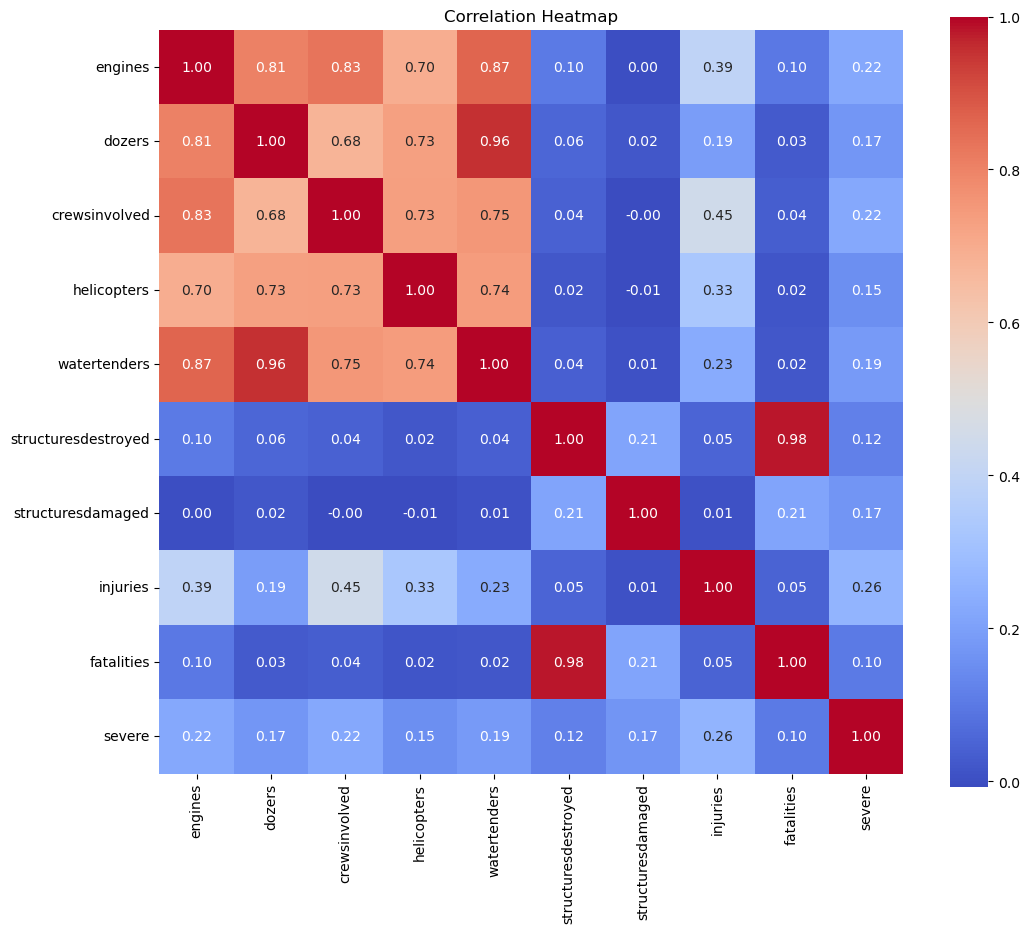

In [9]:
numeric_df = df.select_dtypes(include='number')
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.show()

Pairplot

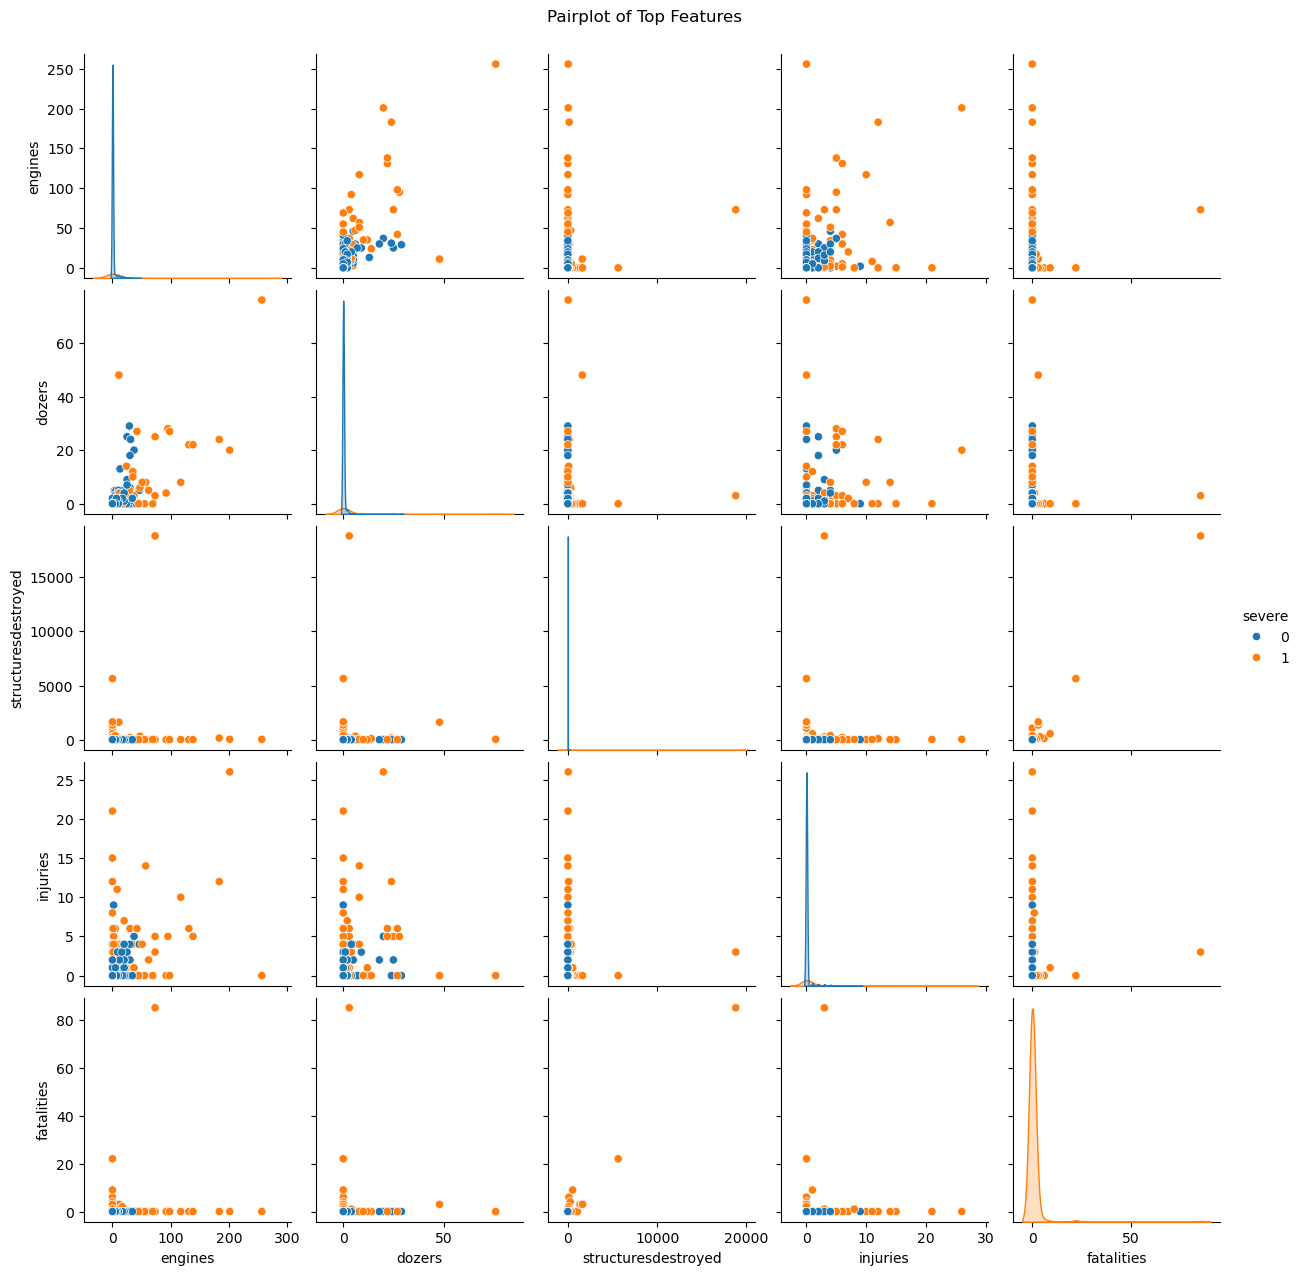

In [10]:
top_vars = ['acresburned', 'engines', 'dozers', 'structuresdestroyed', 'injuries', 'fatalities']
pairplot_vars = [col for col in top_vars if col in df.columns]
if 'severe' in df.columns:
    pairplot_vars.append('severe')

if len(pairplot_vars) >= 3:
    sns.pairplot(df[pairplot_vars], hue='severe' if 'severe' in df.columns else None)
    plt.suptitle("Pairplot of Top Features", y=1.02)
    plt.show()

# Feature Selection

In [11]:
X = df[features]
y = df['severe']

# Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training

In [14]:
results = []

In [15]:
def evaluate_model(name, y_test, y_pred, cm, train_time):
    print(f"\n--- {name} ---")
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.2f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"F1-Score : {f1_score(y_test, y_pred):.2f}")
    print(f"Training Time: {train_time:.4f} seconds")
    print("Confusion Matrix:\n", cm)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

Logistic Regression


--- Logistic Regression ---
Accuracy : 0.87
Recall   : 0.31
Precision: 0.90
F1-Score : 0.46
Training Time: 0.0086 seconds
Confusion Matrix:
 [[265   2]
 [ 42  19]]


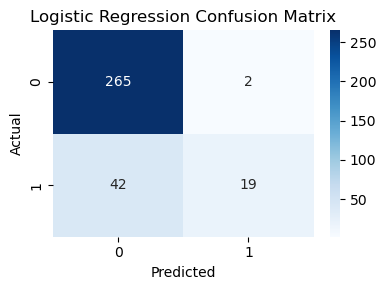

In [16]:
start = time.time()
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
end = time.time()
train_time_lr = time.time() - start

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

results.append({
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_lr,
    'Precision': precision_lr,
    'Recall': recall_lr,
    'F1-Score': f1_lr,
    'Training Time': train_time_lr
})

# Evaluate
cm_lr = confusion_matrix(y_test, y_pred_lr)
evaluate_model("Logistic Regression", y_test, y_pred_lr, cm_lr, train_time_lr)

Normal Random Forest


--- Random Forest (Sequential) ---
Accuracy : 0.87
Recall   : 0.34
Precision: 0.88
F1-Score : 0.49
Training Time: 0.1918 seconds
Confusion Matrix:
 [[264   3]
 [ 40  21]]


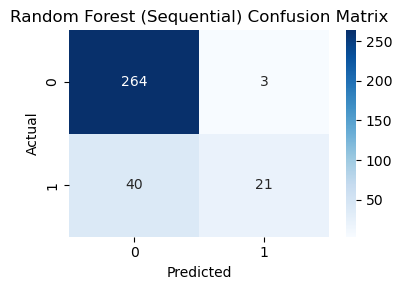

In [17]:
start = time.time()
rf_seq = RandomForestClassifier(random_state=42)
rf_seq.fit(X_train, y_train)
y_pred_rf_seq = rf_seq.predict(X_test)
end = time.time()
train_time_rf_seq = time.time() - start

accuracy_rf_seq = accuracy_score(y_test, y_pred_rf_seq)
precision_rf_seq = precision_score(y_test, y_pred_rf_seq)
recall_rf_seq = recall_score(y_test, y_pred_rf_seq)
f1_rf_seq = f1_score(y_test, y_pred_rf_seq)

results.append({
    'Model': 'Random Forest (Sequential)',
    'Accuracy': accuracy_rf_seq,
    'Precision': precision_rf_seq,
    'Recall': recall_rf_seq,
    'F1-Score': f1_rf_seq,
    'Training Time': train_time_rf_seq
})

cm_rf_seq = confusion_matrix(y_test, y_pred_rf_seq)
evaluate_model("Random Forest (Sequential)", y_test, y_pred_rf_seq, cm_rf_seq, train_time_rf_seq)

Parallel Random Forest


--- Random Forest (Parallel) ---
Accuracy : 0.87
Recall   : 0.34
Precision: 0.84
F1-Score : 0.49
Training Time: 0.1185 seconds
Confusion Matrix:
 [[263   4]
 [ 40  21]]


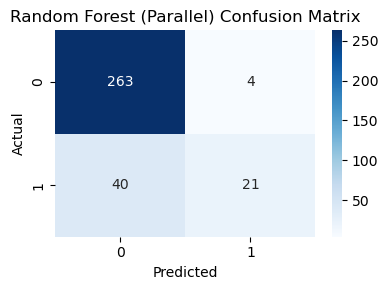

In [36]:
start = time.time()
rf_parallel = RandomForestClassifier(
    n_estimators=50,           # Lowered trees for speed
    max_depth=12,              # Limit depth
    min_samples_split=5,       # Reduce complexity
    n_jobs=-1,
    random_state=42
)
rf_parallel.fit(X_train, y_train)
y_pred_rf_parallel = rf_parallel.predict(X_test)
end = time.time()
train_time_rf_parallel = time.time() - start

accuracy_rf_parallel = accuracy_score(y_test, y_pred_rf_parallel)
precision_rf_parallel = precision_score(y_test, y_pred_rf_parallel)
recall_rf_parallel = recall_score(y_test, y_pred_rf_parallel)
f1_rf_parallel = f1_score(y_test, y_pred_rf_parallel)

results.append({
    'Model': 'Random Forest (Parallel)',
    'Accuracy': accuracy_rf_parallel,
    'Precision': precision_rf_parallel,
    'Recall': recall_rf_parallel,
    'F1-Score': f1_rf_parallel,
    'Training Time': train_time_rf_parallel
})

cm_rf_parallel = confusion_matrix(y_test, y_pred_rf_parallel)
evaluate_model("Random Forest (Parallel)", y_test, y_pred_rf_parallel, cm_rf_parallel, train_time_rf_parallel)

# Model Evalutaion

In [37]:
df_results = pd.DataFrame(results)
print("\nModel Evaluation Summary:")
print(df_results.round(3))


Model Evaluation Summary:
                        Model  Accuracy  Precision  Recall  F1-Score  \
0         Logistic Regression     0.866      0.905   0.311     0.463   
1  Random Forest (Sequential)     0.869      0.875   0.344     0.494   
2    Random Forest (Parallel)     0.866      0.840   0.344     0.488   

   Training Time  
0          0.009  
1          0.192  
2          0.119  


# Visualizations

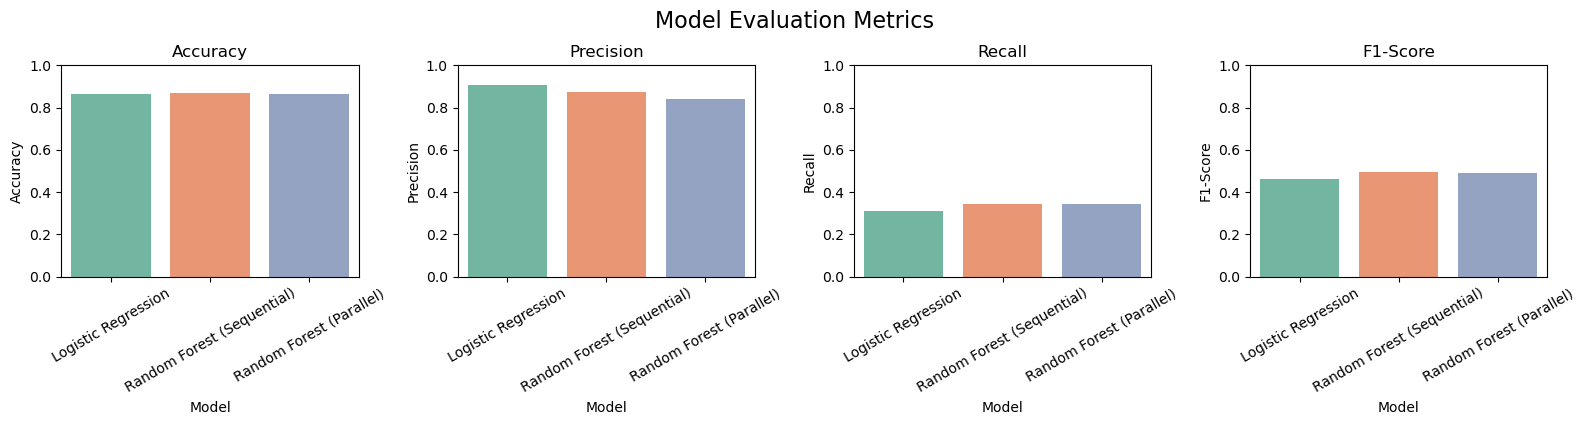

In [38]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

plt.figure(figsize=(16, 4))
for i, metric in enumerate(metrics):
    plt.subplot(1, 4, i+1)
    sns.barplot(x='Model', y=metric, data=df_results, palette='Set2')
    plt.title(metric)
    plt.xticks(rotation=30)
    plt.ylim(0, 1)

plt.tight_layout()
plt.suptitle("Model Evaluation Metrics", y=1.05, fontsize=16)
plt.show()

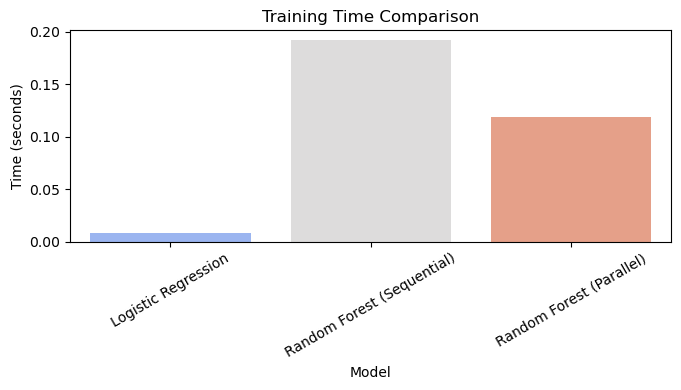

In [39]:
plt.figure(figsize=(7, 4))
sns.barplot(x='Model', y='Training Time', data=df_results, palette='coolwarm')
plt.title("Training Time Comparison")
plt.xticks(rotation=30)
plt.ylabel("Time (seconds)")
plt.tight_layout()
plt.show()